# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jul14-1944'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [5]:
from concord.simulation import (
    Simulation,
    SimConfig,
    TrajectoryConfig,   # ← because state_type == 'trajectory'
    BatchConfig,
)

# ── 1. global simulation settings ──────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1_000,
    n_genes =   100,
    seed    =    42,
    non_neg =  True,
    to_int  =  True,
)

# ── 2. trajectory (state) settings ─────────────────────────────────
traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 2.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.1,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)

# ── 3. batch settings ──────────────────────────────────────────────
batch_cfg = BatchConfig(
    n_batches    = 2,
    effect_type  = "batch_specific_features",    # batch_type
    distribution = "normal",                     # batch_distribution
    level        = [10, 10],                     # batch_level
    dispersion   = [2.0, 2.0],                   # batch_dispersion
    feature_frac = 0.1,                          # matches the old default
    # cell_proportion defaults to [0.5, 0.5] because n_batches = 2
)

# ── 4. run the simulation ──────────────────────────────────────────
sim   = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()

# keep the “counts” layer your downstream code expects
adata.layers["counts"] = adata.X.copy()


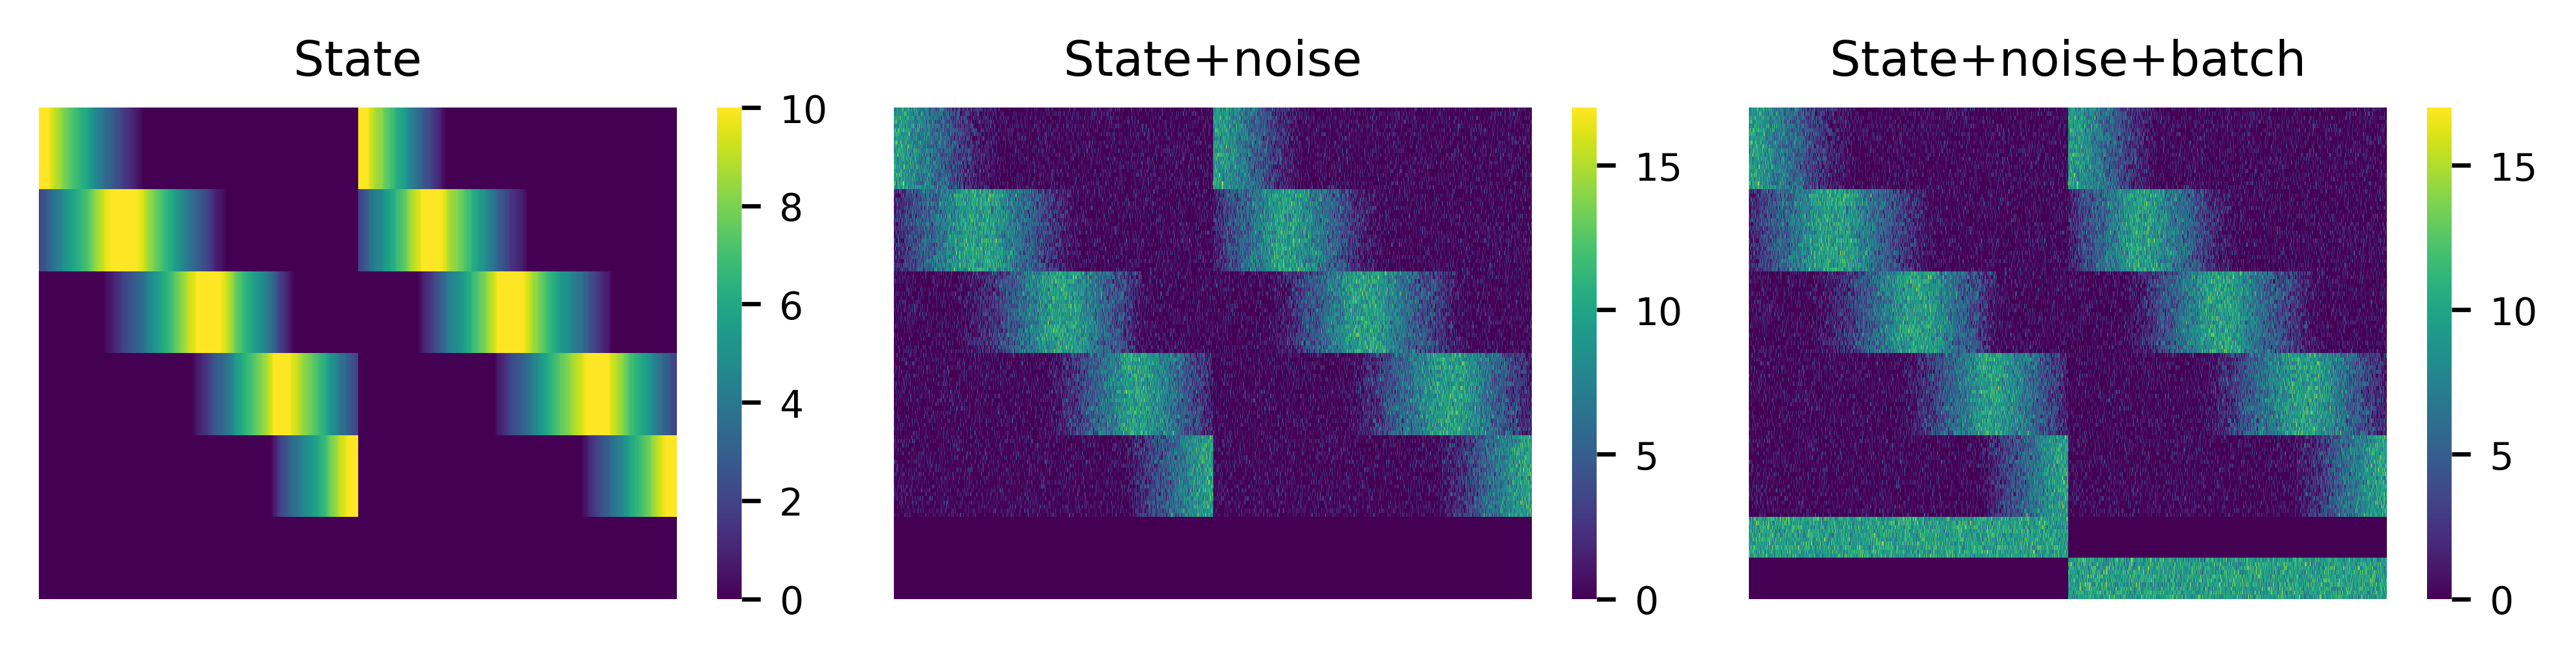

In [6]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

### Integration pipeline

In [35]:
combined_keys = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", "scanvi",
        "concord_hcl", "concord_knn", "contrastive"
    ]
latent_dim = 30

In [23]:
concord_kwargs = {
    'batch_size':64,
    'load_data_into_memory': True, 
    'verbose': True}
benchmark_res = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=42,                              # Random seed for reproducibility
    compute_umap=True,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    concord_kwargs=concord_kwargs,
    verbose=True,                        # Print progress messages
)


concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - INFO - Setting sampler_knn to 100 to be 1/10 the number of cells in the dataset. You can change this value by setting sampler_knn in the configuration.
concord - INFO - KNN sampling mode is enabled.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Proceeding with all 120 features in the dataset.
concord - INFO - Column 'batch' is already of type: category
concord - INFO - Unused levels dropped for column 'batch'.
concord - INFO - Encoder input dim: 120
concord - INFO - Model loaded to device: cpu
concord - INFO - Total

Epoch 0 Training: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s, loss=3.937]

concord - INFO - Epoch   0 | Train Loss: 4.26, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.26, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 1 Training: 100%|██████████| 14/14 [00:02<00:00,  5.71it/s, loss=3.731]

concord - INFO - Epoch   1 | Train Loss: 3.83, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.83, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Warm-up complete. Computing k-NN graph on learned embeddings.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 1000 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 1000 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord.model.dataloader - INFO - Computing k-NN graph using embedding from 'X_concord_warmup'...
concord - INFO - Using euclidean distance metric.
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 1000


Epoch 2 Training: 100%|██████████| 14/14 [00:02<00:00,  5.32it/s, loss=3.750]

concord - INFO - Epoch   2 | Train Loss: 3.79, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.79, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 3 Training: 100%|██████████| 14/14 [00:02<00:00,  5.31it/s, loss=3.830]

concord - INFO - Epoch   3 | Train Loss: 3.76, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.76, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 4 Training: 100%|██████████| 14/14 [00:02<00:00,  5.33it/s, loss=3.700]

concord - INFO - Epoch   4 | Train Loss: 3.68, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.68, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 5 Training: 100%|██████████| 14/14 [00:02<00:00,  5.31it/s, loss=3.808]

concord - INFO - Epoch   5 | Train Loss: 3.72, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.72, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 6 Training: 100%|██████████| 14/14 [00:02<00:00,  5.32it/s, loss=3.702]

concord - INFO - Epoch   6 | Train Loss: 3.74, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.74, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 7 Training: 100%|██████████| 14/14 [00:02<00:00,  5.43it/s, loss=3.650]

concord - INFO - Epoch   7 | Train Loss: 3.67, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.67, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 8 Training: 100%|██████████| 14/14 [00:02<00:00,  5.40it/s, loss=3.560]

concord - INFO - Epoch   8 | Train Loss: 3.66, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.66, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 9 Training: 100%|██████████| 14/14 [00:02<00:00,  5.36it/s, loss=3.603]

concord - INFO - Epoch   9 | Train Loss: 3.65, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.65, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 10 Training: 100%|██████████| 14/14 [00:02<00:00,  5.29it/s, loss=3.515]

concord - INFO - Epoch  10 | Train Loss: 3.58, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.58, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 11 Training: 100%|██████████| 14/14 [00:02<00:00,  5.36it/s, loss=3.537]

concord - INFO - Epoch  11 | Train Loss: 3.60, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.60, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 12 Training: 100%|██████████| 14/14 [00:02<00:00,  5.34it/s, loss=3.681]

concord - INFO - Epoch  12 | Train Loss: 3.64, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.64, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 13 Training: 100%|██████████| 14/14 [00:02<00:00,  5.33it/s, loss=3.923]

concord - INFO - Epoch  13 | Train Loss: 3.59, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.59, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 14 Training: 100%|██████████| 14/14 [00:02<00:00,  5.37it/s, loss=3.507]

concord - INFO - Epoch  14 | Train Loss: 3.59, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.59, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 1000 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'concord_knn'.


concord_knn: 44.40s | 0.00 MB RAM | 0.00 MB VRAM


concord.benchmarking.pipeline_integration - INFO - concord_knn: 44.40s | 0.00 MB RAM | 0.00 MB VRAM
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - INFO - Using NT-Xent loss with beta=1.0. This will apply hard-negative weighting to the contrastive loss.
concord - INFO - HCL (Contrastive learning with hard negative samples) mode is enabled.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Proceeding with all 120 features in the dataset.
concord - INFO - Column 'batch' is already of type: category
concord - INFO - Unused levels dropped for column 'batch'.
concord - IN

Epoch 0 Training: 100%|██████████| 14/14 [00:02<00:00,  5.87it/s, loss=4.482]

concord - INFO - Epoch   0 | Train Loss: 4.61, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.61, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 1 Training: 100%|██████████| 14/14 [00:02<00:00,  5.91it/s, loss=4.441]

concord - INFO - Epoch   1 | Train Loss: 4.48, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.48, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 2 Training: 100%|██████████| 14/14 [00:02<00:00,  5.89it/s, loss=4.411]

concord - INFO - Epoch   2 | Train Loss: 4.44, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.44, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 3 Training: 100%|██████████| 14/14 [00:02<00:00,  5.92it/s, loss=4.390]

concord - INFO - Epoch   3 | Train Loss: 4.43, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.43, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 4 Training: 100%|██████████| 14/14 [00:02<00:00,  5.77it/s, loss=4.436]

concord - INFO - Epoch   4 | Train Loss: 4.42, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.42, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 5 Training: 100%|██████████| 14/14 [00:02<00:00,  5.71it/s, loss=4.394]

concord - INFO - Epoch   5 | Train Loss: 4.43, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.43, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 6 Training: 100%|██████████| 14/14 [00:02<00:00,  5.94it/s, loss=4.370]

concord - INFO - Epoch   6 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 7 Training: 100%|██████████| 14/14 [00:02<00:00,  5.92it/s, loss=4.393]

concord - INFO - Epoch   7 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 8 Training: 100%|██████████| 14/14 [00:02<00:00,  5.88it/s, loss=4.373]

concord - INFO - Epoch   8 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 9 Training: 100%|██████████| 14/14 [00:02<00:00,  5.94it/s, loss=4.426]

concord - INFO - Epoch   9 | Train Loss: 4.39, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.39, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 10 Training: 100%|██████████| 14/14 [00:02<00:00,  5.92it/s, loss=4.437]

concord - INFO - Epoch  10 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 11 Training: 100%|██████████| 14/14 [00:02<00:00,  5.90it/s, loss=4.361]

concord - INFO - Epoch  11 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 12 Training: 100%|██████████| 14/14 [00:02<00:00,  5.89it/s, loss=4.423]

concord - INFO - Epoch  12 | Train Loss: 4.40, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.40, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 13 Training: 100%|██████████| 14/14 [00:02<00:00,  5.88it/s, loss=4.402]

concord - INFO - Epoch  13 | Train Loss: 4.39, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.39, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 14 Training: 100%|██████████| 14/14 [00:02<00:00,  5.86it/s, loss=4.341]

concord - INFO - Epoch  14 | Train Loss: 4.38, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.38, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 1000 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'concord_hcl'.


concord_hcl: 38.08s | 0.00 MB RAM | 0.00 MB VRAM


concord.benchmarking.pipeline_integration - INFO - concord_hcl: 38.08s | 0.00 MB RAM | 0.00 MB VRAM
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Proceeding with all 120 features in the dataset.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
concord - INFO - Encoder input dim: 120
concord - INFO - Model loaded to device: cpu
concord - INFO - Total number of parameters: 153098


Epoch 0 Training: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s, loss=3.961]

concord - INFO - Epoch   0 | Train Loss: 4.16, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.16, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 1 Training: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, loss=3.706]

concord - INFO - Epoch   1 | Train Loss: 3.76, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.76, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 2 Training: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, loss=3.632]

concord - INFO - Epoch   2 | Train Loss: 3.65, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.65, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 3 Training: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, loss=3.495]

concord - INFO - Epoch   3 | Train Loss: 3.56, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.56, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 4 Training: 100%|██████████| 15/15 [00:02<00:00,  6.20it/s, loss=3.469]

concord - INFO - Epoch   4 | Train Loss: 3.44, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.44, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 5 Training: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, loss=3.370]

concord - INFO - Epoch   5 | Train Loss: 3.38, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.38, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 6 Training: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s, loss=3.238]

concord - INFO - Epoch   6 | Train Loss: 3.34, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.34, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 7 Training: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, loss=3.437]

concord - INFO - Epoch   7 | Train Loss: 3.30, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.30, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 8 Training: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s, loss=3.322]

concord - INFO - Epoch   8 | Train Loss: 3.36, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.36, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 9 Training: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, loss=3.231]

concord - INFO - Epoch   9 | Train Loss: 3.27, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.27, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 10 Training: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s, loss=3.227]

concord - INFO - Epoch  10 | Train Loss: 3.22, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.22, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 11 Training: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s, loss=3.217]

concord - INFO - Epoch  11 | Train Loss: 3.24, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.24, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 12 Training: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s, loss=3.258]

concord - INFO - Epoch  12 | Train Loss: 3.25, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.25, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 13 Training: 100%|██████████| 15/15 [00:02<00:00,  6.26it/s, loss=3.169]

concord - INFO - Epoch  13 | Train Loss: 3.18, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.18, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 1000



Epoch 14 Training: 100%|██████████| 15/15 [00:02<00:00,  6.33it/s, loss=3.206]

concord - INFO - Epoch  14 | Train Loss: 3.22, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.22, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 1000 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'contrastive'.


contrastive: 38.37s | 0.56 MB RAM | 0.00 MB VRAM


concord.benchmarking.pipeline_integration - INFO - contrastive: 38.37s | 0.56 MB RAM | 0.00 MB VRAM


Running UMAP on unintegrated …


concord.benchmarking.pipeline_integration - INFO - Running UMAP on unintegrated …
concord - INFO - UMAP embedding stored in adata.obsm['unintegrated_UMAP']
Found 120 genes among all datasets
[[0.    0.002]
 [0.    0.   ]]


scanorama: 0.06s | 0.25 MB RAM | 0.00 MB VRAM


concord.benchmarking.pipeline_integration - INFO - scanorama: 0.06s | 0.25 MB RAM | 0.00 MB VRAM


100%|██████████| 30/30 [00:06<00:00,  4.92it/s]
liger: 6.23s | 0.03 MB RAM | 0.00 MB VRAM


concord.benchmarking.pipeline_integration - INFO - liger: 6.23s | 0.03 MB RAM | 0.00 MB VRAM
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).


harmony: 0.94s | 0.00 MB RAM | 0.00 MB VRAM


	Completed 10 / 10 iteration(s).
concord.benchmarking.pipeline_integration - INFO - harmony: 0.94s | 0.00 MB RAM | 0.00 MB VRAM


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi: 16.39s | 0.08 MB RAM | 0.00 MB VRAM


concord.benchmarking.pipeline_integration - INFO - scvi: 16.39s | 0.08 MB RAM | 0.00 MB VRAM


❌ scanvi failed: Making .obs["time"] categorical failed. Expected categories: ['2.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0' '10.0' '12.0' '14.0' '15.0'
 '16.0' '17.0' '18.0' '19.0' '22.0' '23.0' '24.0' '25.0' '28.0' '29.0'
 '30.0' '31.0' '33.0' '34.0' '37.0' '38.0' '40.0' '41.0' '43.0' '44.0'
 '47.0' '48.0' '49.0' '50.0' '54.0' '56.0' '57.0' '58.0' '59.0' '60.0'
 '61.0' '62.0' '64.0' '65.0' '66.0' '68.0' '69.0' '70.0' '71.0' '73.0'
 '74.0' '75.0' '76.0' '78.0' '79.0' '80.0' '82.0' '83.0' '86.0' '87.0'
 '88.0' '89.0' '91.0' '92.0' '93.0' '94.0' '95.0' '96.0' '98.0' '99.0'
 '100.0' '101.0' '102.0' '103.0' '104.0' '106.0' '107.0' '108.0' '109.0'
 '111.0' '112.0' '113.0' '114.0' '115.0' '117.0' '118.0' '120.0' '121.0'
 '122.0' '124.0' '126.0' '129.0' '130.0' '131.0' '132.0' '134.0' '135.0'
 '136.0' '137.0' '138.0' '139.0' '140.0' '141.0' '143.0' '146.0' '147.0'
 '149.0' '151.0' '153.0' '154.0' '155.0' '158.0' '159.0' '160.0' '164.0'
 '167.0' '168.0' '169.0' '170.0' '171.0' '172.0' '174.0' '17

concord.benchmarking.pipeline_integration - ERROR - ❌ scanvi failed: Making .obs["time"] categorical failed. Expected categories: ['2.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0' '10.0' '12.0' '14.0' '15.0'
 '16.0' '17.0' '18.0' '19.0' '22.0' '23.0' '24.0' '25.0' '28.0' '29.0'
 '30.0' '31.0' '33.0' '34.0' '37.0' '38.0' '40.0' '41.0' '43.0' '44.0'
 '47.0' '48.0' '49.0' '50.0' '54.0' '56.0' '57.0' '58.0' '59.0' '60.0'
 '61.0' '62.0' '64.0' '65.0' '66.0' '68.0' '69.0' '70.0' '71.0' '73.0'
 '74.0' '75.0' '76.0' '78.0' '79.0' '80.0' '82.0' '83.0' '86.0' '87.0'
 '88.0' '89.0' '91.0' '92.0' '93.0' '94.0' '95.0' '96.0' '98.0' '99.0'
 '100.0' '101.0' '102.0' '103.0' '104.0' '106.0' '107.0' '108.0' '109.0'
 '111.0' '112.0' '113.0' '114.0' '115.0' '117.0' '118.0' '120.0' '121.0'
 '122.0' '124.0' '126.0' '129.0' '130.0' '131.0' '132.0' '134.0' '135.0'
 '136.0' '137.0' '138.0' '139.0' '140.0' '141.0' '143.0' '146.0' '147.0'
 '149.0' '151.0' '153.0' '154.0' '155.0' '158.0' '159.0' '160.0' '164.0'
 '167.0'

✅ All selected methods completed.


concord.benchmarking.pipeline_integration - INFO - ✅ All selected methods completed.


In [24]:
benchmark_res

time_sec    ram_MB  vram_MB
concord_hcl  38.081812  0.000000      0.0
concord_knn  44.401309  0.000000      0.0
contrastive  38.373684  0.562500      0.0
harmony       0.936124  0.000000      0.0
liger         6.226209  0.031250      0.0
scanorama     0.062709  0.250000      0.0
scanvi             NaN       NaN      NaN
scvi         16.385437  0.078125      0.0

In [26]:
benchmark_res

time_sec    ram_MB  vram_MB
concord_hcl  38.081812  0.000000      0.0
concord_knn  44.401309  0.000000      0.0
contrastive  38.373684  0.562500      0.0
harmony       0.936124  0.000000      0.0
liger         6.226209  0.031250      0.0
scanorama     0.062709  0.250000      0.0
scanvi             NaN       NaN      NaN
scvi         16.385437  0.078125      0.0

In [36]:
# Run umap and PCA for all latent embeddings
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
max_pc = 15
# Remove nan rows from benchmark_res
benchmark_res = benchmark_res[benchmark_res['time_sec'].notna()]
combined_keys = [key for key in benchmark_res.index if key in combined_keys]
print(combined_keys)
for basis in combined_keys:
    print("Running UMAP", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)


['concord_hcl', 'concord_knn', 'contrastive', 'harmony', 'liger', 'scanorama', 'scvi']
Running UMAP concord_hcl
concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
Running UMAP concord_knn
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
Running UMAP contrastive
concord - INFO - UMAP embedding stored in adata.obsm['contrastive_UMAP']
Running UMAP harmony
concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']
Running UMAP liger
concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP']
Running UMAP scanorama
concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP']
Running UMAP scvi
concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP']


concord.plotting.pl_embedding - INFO - Plotting no_noise with time in KNN
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in KNN
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in KNN
concord.plotting.pl_embedding - INFO - Plotting harmony with time in KNN
concord.plotting.pl_embedding - INFO - Plotting liger with time in KNN
concord.plotting.pl_embedding - INFO - Plotting scanorama with time in KNN
concord.plotting.pl_embedding - INFO - Plotting scvi with time in KNN


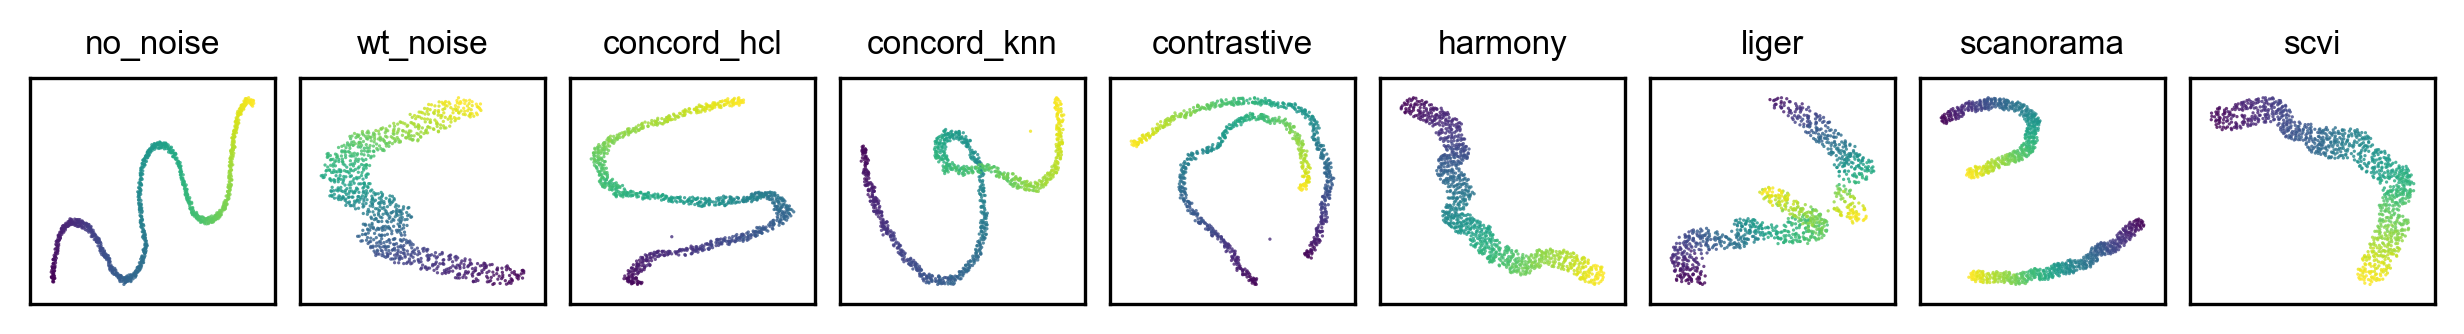

concord.plotting.pl_embedding - INFO - Plotting no_noise with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting wt_noise with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting liger with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in KNN


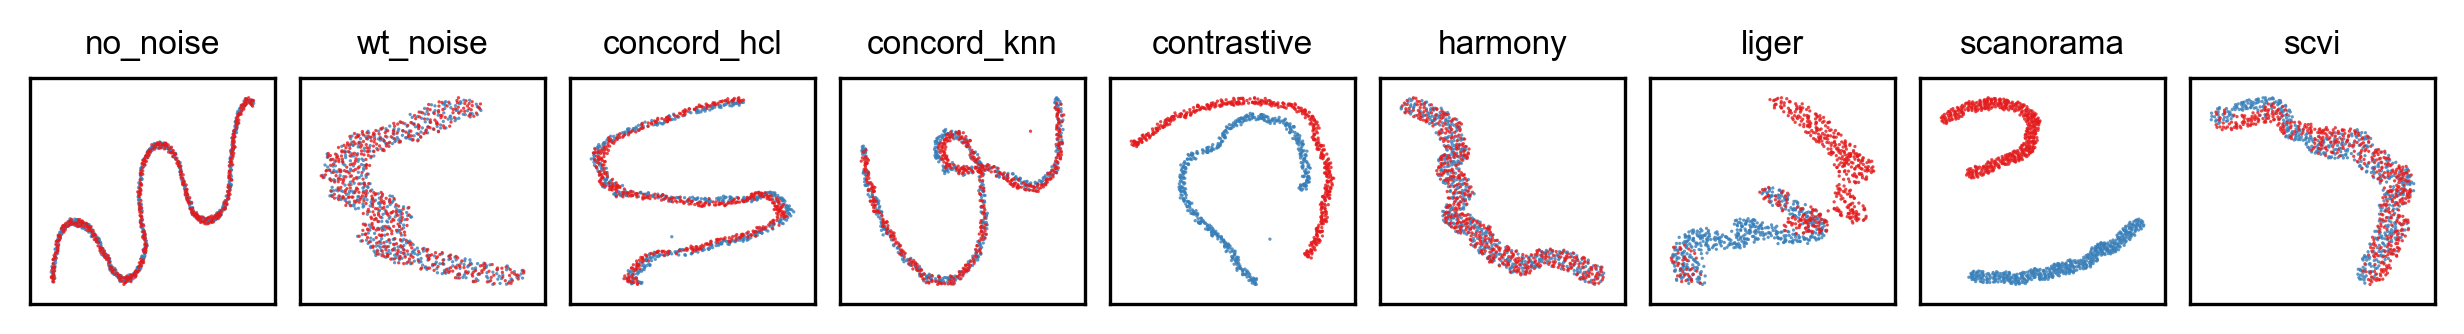

concord.plotting.pl_embedding - INFO - Plotting no_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with time in UMAP


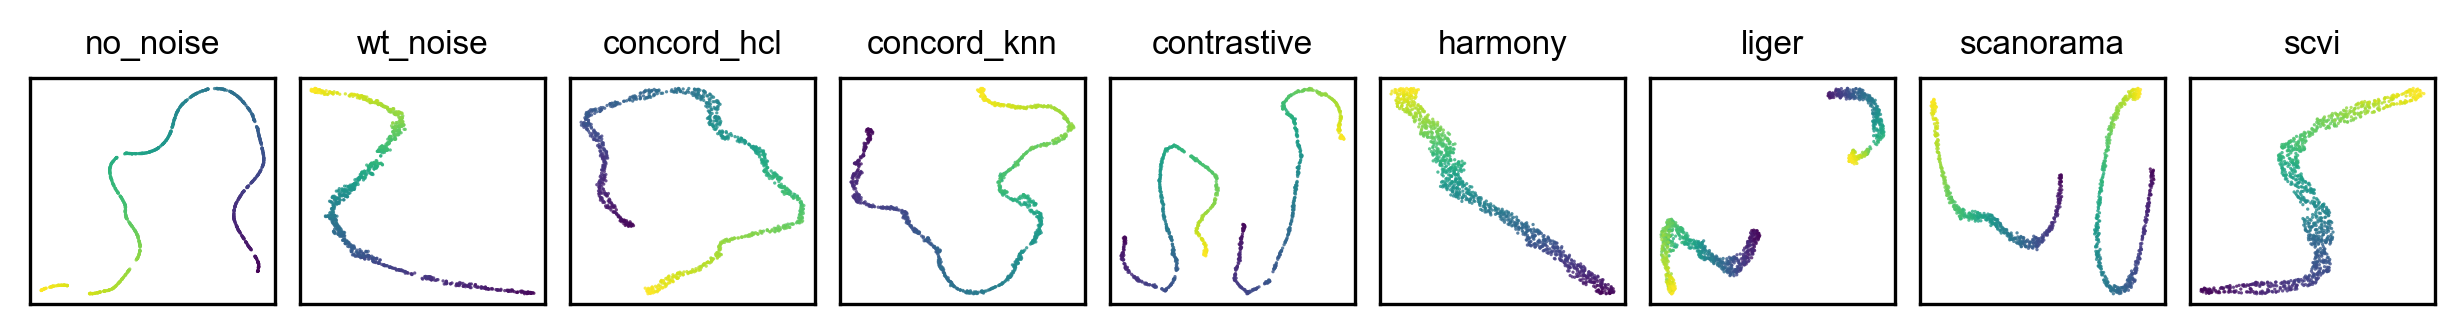

concord.plotting.pl_embedding - INFO - Plotting no_noise with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in UMAP


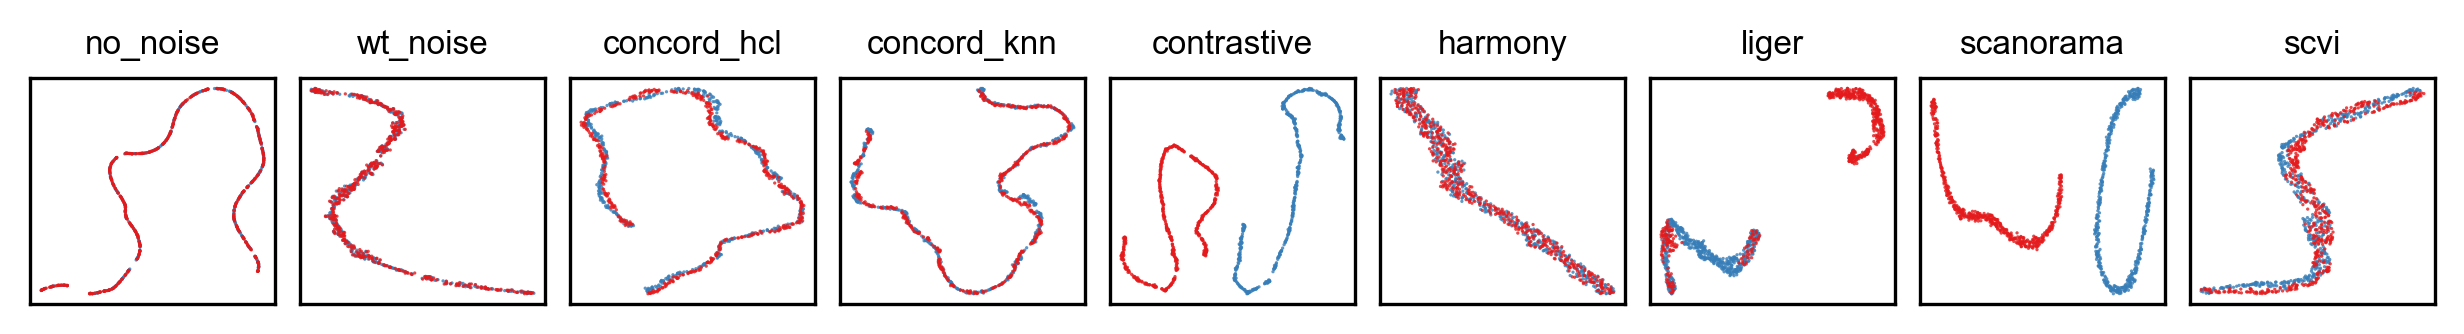

In [37]:
# plot everything
import matplotlib.pyplot as plt

show_keys = ['no_noise', 'wt_noise'] + [key for key in combined_keys if key in adata.obsm.keys()]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [17]:
adata.layers['no_noise'] = np.zeros_like(adata.X)
adata.layers['wt_noise'] = np.zeros_like(adata.X)
# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()
adata.layers['wt_noise'][:, adata_indices] = adata_state.layers['wt_noise'][:, adata_state_indices].copy()

# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord', path=batch_indices, sigma=2)
adata.obsm['concord_sorted'] = adata.obsm['concord'][:, feature_order]


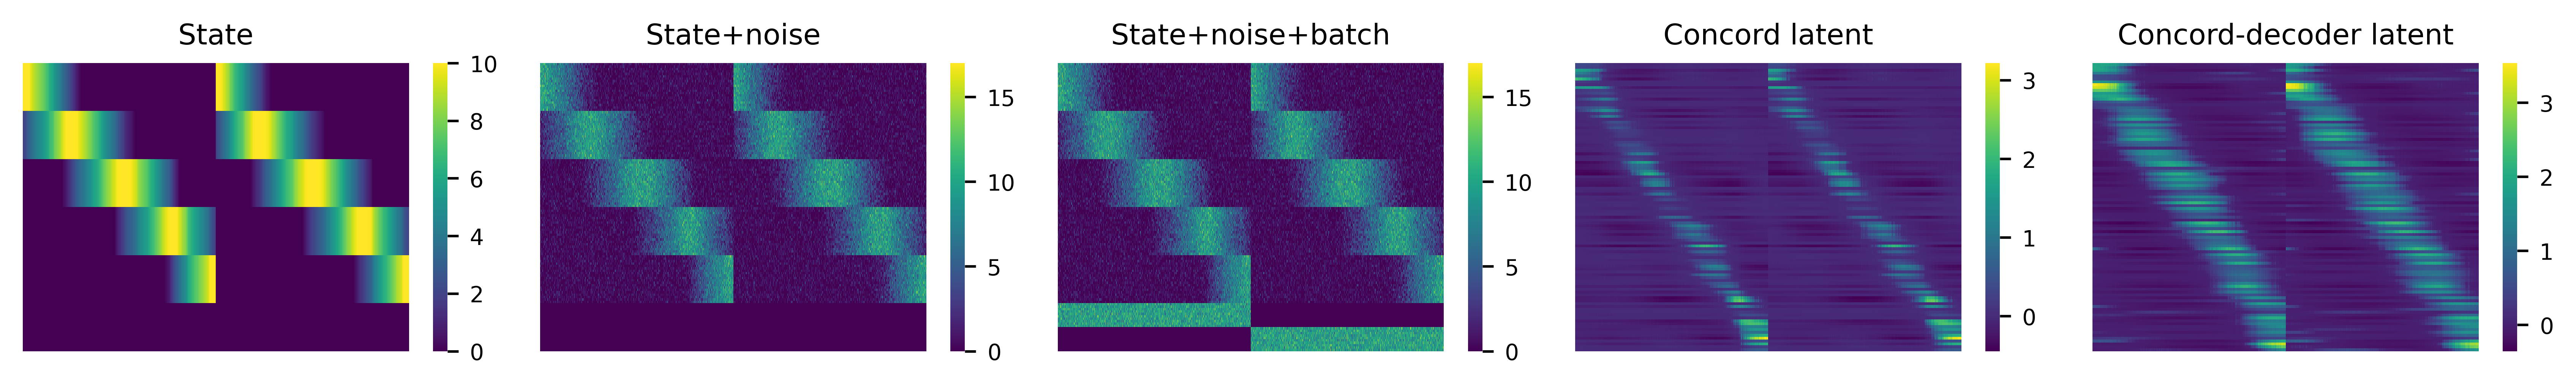

In [ ]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [18]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory/adata_Jun18-1644.h5ad
Saved adata_state to ../data/simulation_trajectory/adata_state_Jun18-1644.h5ad


# Evaluation

In [19]:
adata = sc.read(data_dir / f"adata_Jun18-1644.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jun18-1644.h5ad")

### Scib

In [20]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

In [21]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
combined_keys = [key for key in combined_keys if key in adata.obsm.keys()]
bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=leiden_key,
    embedding_obsm_keys=combined_keys,
    n_jobs=6,
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
)
bm.benchmark()

Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings:  14%|█▍        | 1/7 [00:15<01:30, 15.01s/it]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings:  29%|██▊       | 2/7 [00:15<00:33,  6.74s/it]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings:  43%|████▎     | 3/7 [00:16<00:16,  4.07s/it]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings:  57%|█████▋    | 4/7 [00:17<00:08,  2.83s/it]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings:  71%|███████▏  | 5/7 [00:18<00:04,  2.15s/it]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings:  86%|████████▌ | 6/7 [00:19<00:01,  1.75s/it]

INFO     24 clusters consist of a single batch or are too small. Skip.                                             


Embeddings: 100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


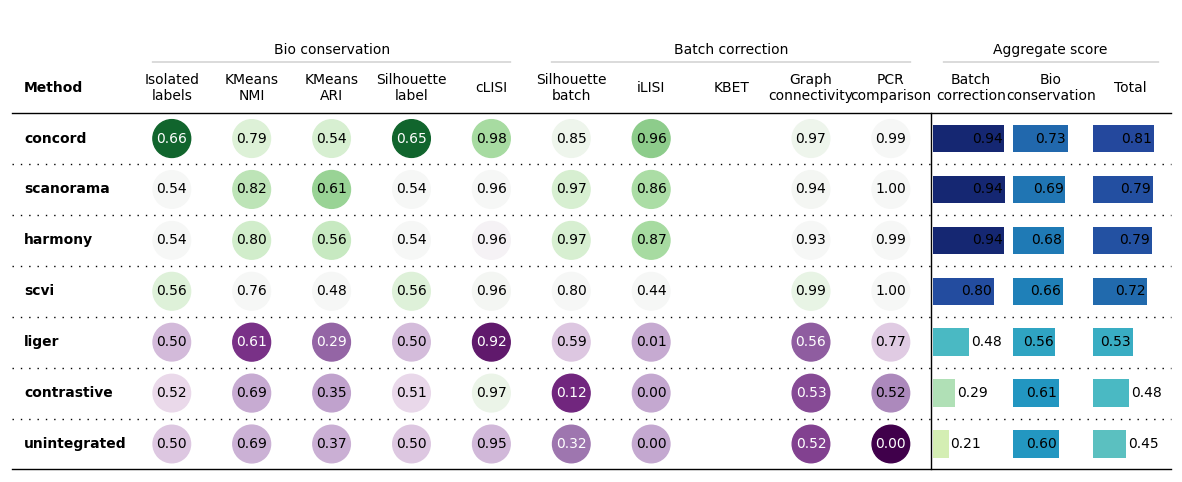

In [22]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

In [27]:
progress = bm._emb_adatas.values()
progress

dict_values([AnnData object with n_obs × n_vars = 1000 × 30
    obs: 'time', 'batch', 'batch_id', 'tmp_domain_label', '_scvi_batch', '_scvi_labels', 'leiden_no_noise', 'labels'
    uns: '15_neighbor_res', '50_neighbor_res', '90_neighbor_res'
    obsm: 'X_pre', AnnData object with n_obs × n_vars = 1000 × 30
    obs: 'time', 'batch', 'batch_id', 'tmp_domain_label', '_scvi_batch', '_scvi_labels', 'leiden_no_noise', 'labels'
    uns: '15_neighbor_res', '50_neighbor_res', '90_neighbor_res'
    obsm: 'X_pre', AnnData object with n_obs × n_vars = 1000 × 30
    obs: 'time', 'batch', 'batch_id', 'tmp_domain_label', '_scvi_batch', '_scvi_labels', 'leiden_no_noise', 'labels'
    uns: '15_neighbor_res', '50_neighbor_res', '90_neighbor_res'
    obsm: 'X_pre', AnnData object with n_obs × n_vars = 1000 × 30
    obs: 'time', 'batch', 'batch_id', 'tmp_domain_label', '_scvi_batch', '_scvi_labels', 'leiden_no_noise', 'labels'
    uns: '15_neighbor_res', '50_neighbor_res', '90_neighbor_res'
    obsm: 'X_p

In [35]:
ad1 = list(progress)[0]

In [37]:
ad1.uns['50_neighbor_res']

NeighborsResults(indices=array([[  0,   3,   6, ...,  45,  54,  44],
       [  1,   4,  13, ...,  54,  46,  50],
       [  2,   4,  12, ...,  60,  54,  45],
       ...,
       [997, 992, 999, ..., 949, 953, 958],
       [998, 982, 968, ..., 956, 954, 946],
       [999, 992, 982, ..., 962, 954, 956]], shape=(1000, 50), dtype=int32), distances=array([[ 0.       ,  7.3030005,  8.461998 , ..., 22.191536 , 22.41135  ,
        23.08689  ],
       [ 0.       ,  9.551744 ,  9.944095 , ..., 20.56839  , 20.865858 ,
        21.048502 ],
       [ 0.       ,  8.450954 ,  8.903225 , ..., 22.751404 , 23.154636 ,
        23.288755 ],
       ...,
       [ 0.       ,  9.889527 , 10.197296 , ..., 23.20542  , 23.51473  ,
        24.219612 ],
       [ 0.       ,  9.799994 , 10.388143 , ..., 19.873972 , 20.288681 ,
        20.387842 ],
       [ 0.       ,  8.648574 , 10.010731 , ..., 20.030388 , 20.294136 ,
        20.302814 ]], shape=(1000, 50), dtype=float32))

In [56]:

from scib_metrics.nearest_neighbors import NeighborsResults
import scipy
from functools import partial
import jax
import jax.numpy as jnp
import pandas as pd
import chex
from scib_metrics._types import NdArray
from scib_metrics.utils import diffusion_nn, get_ndarray

def _chi2_cdf(df: int | NdArray, x: NdArray) -> float:
    """Chi2 cdf.

    See https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.chdtr.html
    for explanation of gammainc.
    """
    return jax.scipy.special.gammainc(df / 2, x / 2)

@partial(jax.jit, static_argnums=2)
def _kbet(neigh_batch_ids: jnp.ndarray, batches: jnp.ndarray, n_batches: int) -> float:
    expected_freq = jnp.bincount(batches, length=n_batches)
    expected_freq = expected_freq / jnp.sum(expected_freq)
    dof = n_batches - 1

    observed_counts = jax.vmap(partial(jnp.bincount, length=n_batches))(neigh_batch_ids)
    expected_counts = expected_freq * neigh_batch_ids.shape[1]
    test_statistics = jnp.sum(jnp.square(observed_counts - expected_counts) / expected_counts, axis=1)
    p_values = 1 - jax.vmap(_chi2_cdf, in_axes=(None, 0))(dof, test_statistics)

    return test_statistics, p_values

def kbet(X: NeighborsResults, batches: np.ndarray, alpha: float = 0.05) -> float:
    if len(batches) != len(X.indices):
        raise ValueError("Length of batches does not match number of cells.")
    knn_idx = X.indices
    batches = np.asarray(pd.Categorical(batches).codes)
    neigh_batch_ids = batches[knn_idx]
    chex.assert_equal_shape([neigh_batch_ids, knn_idx])
    n_batches = jnp.unique(batches).shape[0]
    test_statistics, p_values = _kbet(neigh_batch_ids, batches, n_batches)
    test_statistics = get_ndarray(test_statistics)
    p_values = get_ndarray(p_values)
    acceptance_rate = (p_values >= alpha).mean()

    return acceptance_rate, test_statistics, p_values


def kbet_per_label(
    X: NeighborsResults,
    batches: np.ndarray,
    labels: np.ndarray,
    alpha: float = 0.05,
    diffusion_n_comps: int = 100,
    return_df: bool = False,
) -> float | tuple[float, pd.DataFrame]:
    """Compute kBET score per cell type label as in :cite:p:`luecken2022benchmarking`.

    This approximates the method used in the original scib package. Notably, the underlying
    kbet might have some inconsistencies with the R implementation. Furthermore, to equalize
    the neighbor graphs of cell type subsets we use diffusion distance approximated with diffusion
    maps. Increasing `diffusion_n_comps` will increase the accuracy of the approximation.

    Parameters
    ----------
    X
        A :class:`~scib_metrics.utils.nearest_neighbors.NeighborsResults` object.
    batches
        Array of shape (n_cells,) representing batch values
        for each cell.
    alpha
        Significance level for the statistical test.
    diffusion_n_comps
        Number of diffusion components to use for diffusion distance approximation.
    return_df
        Return dataframe of results in addition to score.

    Returns
    -------
    kbet_score
        Kbet score over all cells. Higher means more integrated, as in the kBET acceptance rate.
    df
        Dataframe with kBET score per cell type label.

    Notes
    -----
    This function requires X to be cell-cell connectivities, not distances.
    """
    if len(batches) != len(X.indices):
        raise ValueError("Length of batches does not match number of cells.")
    if len(labels) != len(X.indices):
        raise ValueError("Length of labels does not match number of cells.")
    # set upper bound for k0
    size_max = 2**31 - 1
    batches = np.asarray(pd.Categorical(batches).codes)
    labels = np.asarray(labels)

    conn_graph = X.knn_graph_connectivities

    # prepare call of kBET per cluster
    clusters = []
    clusters, counts = np.unique(labels, return_counts=True)
    skipped = clusters[counts <= 10]
    clusters = clusters[counts > 10]
    kbet_scores = {"cluster": list(skipped), "kBET": [np.nan] * len(skipped)}
    for clus in clusters:
        # subset by label
        
        mask = labels == clus
        conn_graph_sub = conn_graph[mask, :][:, mask]
        conn_graph_sub.sort_indices()
        n_obs = conn_graph_sub.shape[0]
        batches_sub = batches[mask]

        quarter_mean = np.floor(np.mean(pd.Series(batches_sub).value_counts()) / 4).astype("int")
        k0 = np.min([70, np.max([10, quarter_mean])])
        # check k0 for reasonability
        if k0 * n_obs >= size_max:
            k0 = np.floor(size_max / n_obs).astype("int")

        n_comp, labs = scipy.sparse.csgraph.connected_components(conn_graph_sub, connection="strong")
        if n_comp == 1:  # a single component to compute kBET on
            try:
                diffusion_n_comps = np.min([diffusion_n_comps, n_obs - 1])
                nn_graph_sub = diffusion_nn(conn_graph_sub, k=k0, n_comps=diffusion_n_comps)
                # call kBET
                score, _, _ = kbet(
                    nn_graph_sub,
                    batches=batches_sub,
                    alpha=alpha,
                )
            except ValueError:
                #logger.info("Diffusion distance failed. Skip.")
                score = 0  # i.e. 100% rejection

        else:
            # check the number of components where kBET can be computed upon
            comp_size = pd.Series(labs).value_counts()
            # check which components are small
            comp_size_thresh = 3 * k0
            idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

            # check if 75% of all cells can be used for kBET run
            if len(idx_nonan) / len(labs) >= 0.75:
                # create another subset of components, assume they are not visited in a diffusion process
                conn_graph_sub_sub = conn_graph_sub[idx_nonan, :][:, idx_nonan]
                conn_graph_sub_sub.sort_indices()

                try:
                    diffusion_n_comps = np.min([diffusion_n_comps, conn_graph_sub_sub.shape[0] - 1])
                    nn_results_sub_sub = diffusion_nn(conn_graph_sub_sub, k=k0, n_comps=diffusion_n_comps)
                    # call kBET
                    score, _, _ = kbet(
                        nn_results_sub_sub,
                        batches=batches_sub[idx_nonan],
                        alpha=alpha,
                    )
                except ValueError:
                    logger.info("Diffusion distance failed. Skip.")
                    score = 0  # i.e. 100% rejection
            else:  # if there are too many too small connected components, set kBET score to 0
                score = 0  # i.e. 100% rejection

        kbet_scores["cluster"].append(clus)
        kbet_scores["kBET"].append(score)

    kbet_scores = pd.DataFrame.from_dict(kbet_scores)
    kbet_scores = kbet_scores.reset_index(drop=True)

    final_score = np.nanmean(kbet_scores["kBET"])
    if not return_df:
        return final_score
    else:
        return final_score, kbet_scores

In [60]:
ad2 = list(progress)[2]

In [61]:
kbet_per_label(ad2.uns["50_neighbor_res"], ad2.obs['batch'], ad2.obs['leiden_no_noise'])


np.float64(0.12788863689696453)

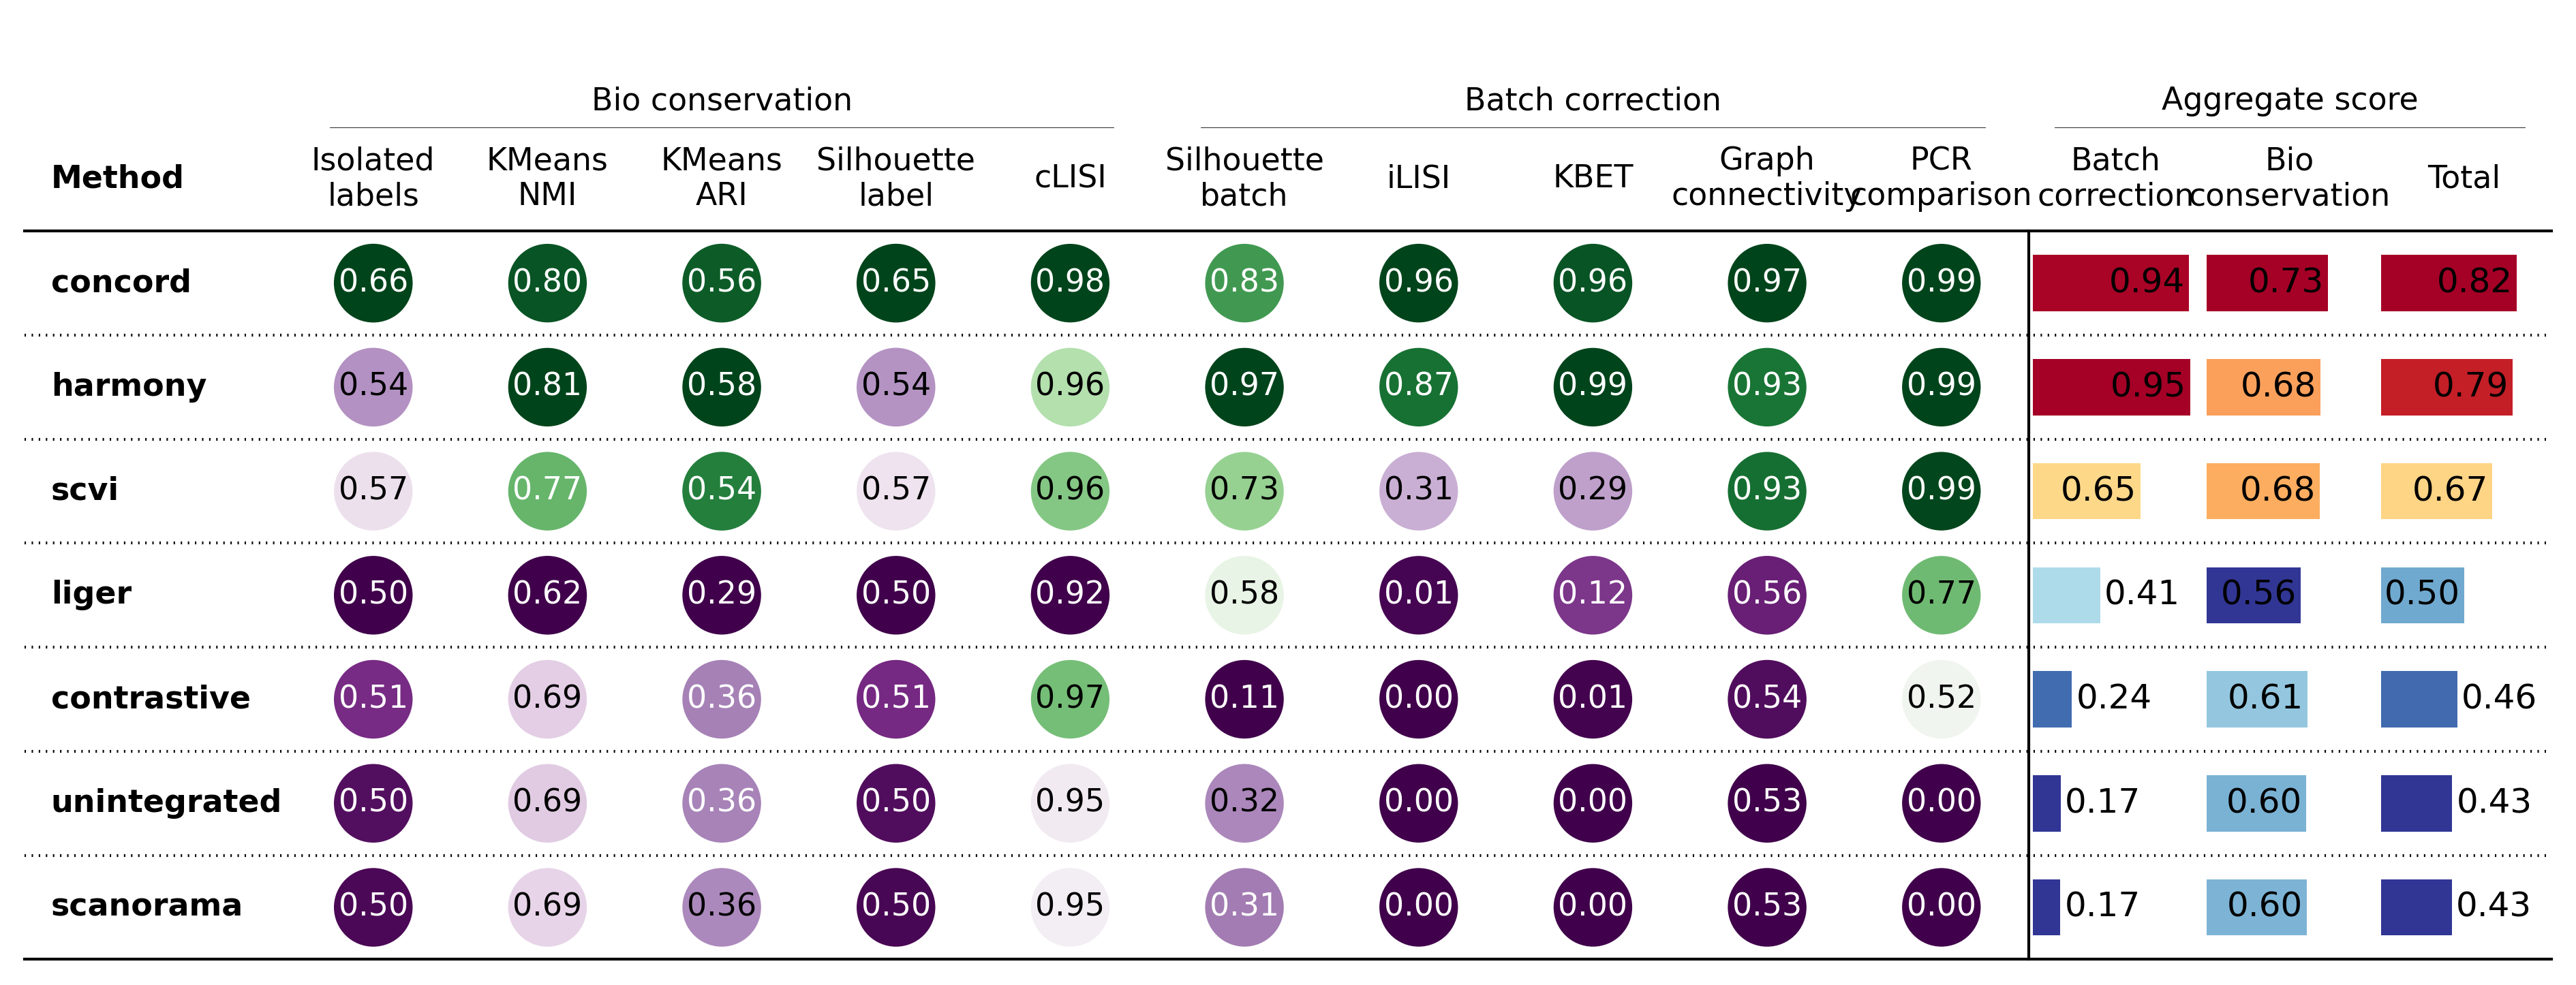

In [ ]:
scib_scores = bm.get_results(min_max_scale=False)
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.bm.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

ccd.pl.plot_benchmark_table(scib_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 6), dpi=300)

### Topology

Run topological analysis pipeline:

In [ ]:
homology_dimensions = [0,1,2]
diagrams = {}
#for key in combined_keys:
for key in combined_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.bm.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

print(f"Saved topology diagrams to {save_dir / f'topology_diagrams_{file_suffix}.pkl'}")

Computing persistent homology for unintegrated
Computing persistent homology for scanorama
Computing persistent homology for liger
Computing persistent homology for harmony
Computing persistent homology for scvi
Computing persistent homology for concord
Computing persistent homology for contrastive


In [ ]:
import pickle
with open('../save/dev_simulation_trajectory-Jun18/topology_diagrams_Jun18-1529.pkl', 'rb') as f:
    diagrams = pickle.load(f)

In [ ]:
topology_results

{'betti_stats': Dimension        Dim 0                                      Dim 1         \
 Statistic      Entropy    Mean Median Mode     Variance   Entropy   Mean   
 Method                                                                     
 concord       1.823823   42.99    0.0  0.0   32696.1699  2.260308   1.13   
 contrastive   1.804362   37.29    1.0  1.0   27443.0259  3.407532   0.85   
 harmony       3.250854  207.39    0.0  0.0  131271.2579  2.139169   7.72   
 liger         3.559444  295.11    4.0  0.0  178996.0179  3.296095  16.21   
 scanorama     3.234084  224.46    1.0  1.0  158756.6484  2.566127   7.52   
 scvi          2.396824   84.38    0.0  0.0   64467.7756  2.488651   5.30   
 unintegrated  3.336646  251.10    1.0  1.0  172070.0900  2.517481   7.95   
 
 Dimension                               Dim 2                             
 Statistic    Median Mode   Variance   Entropy  Mean Median Mode Variance  
 Method                                                      

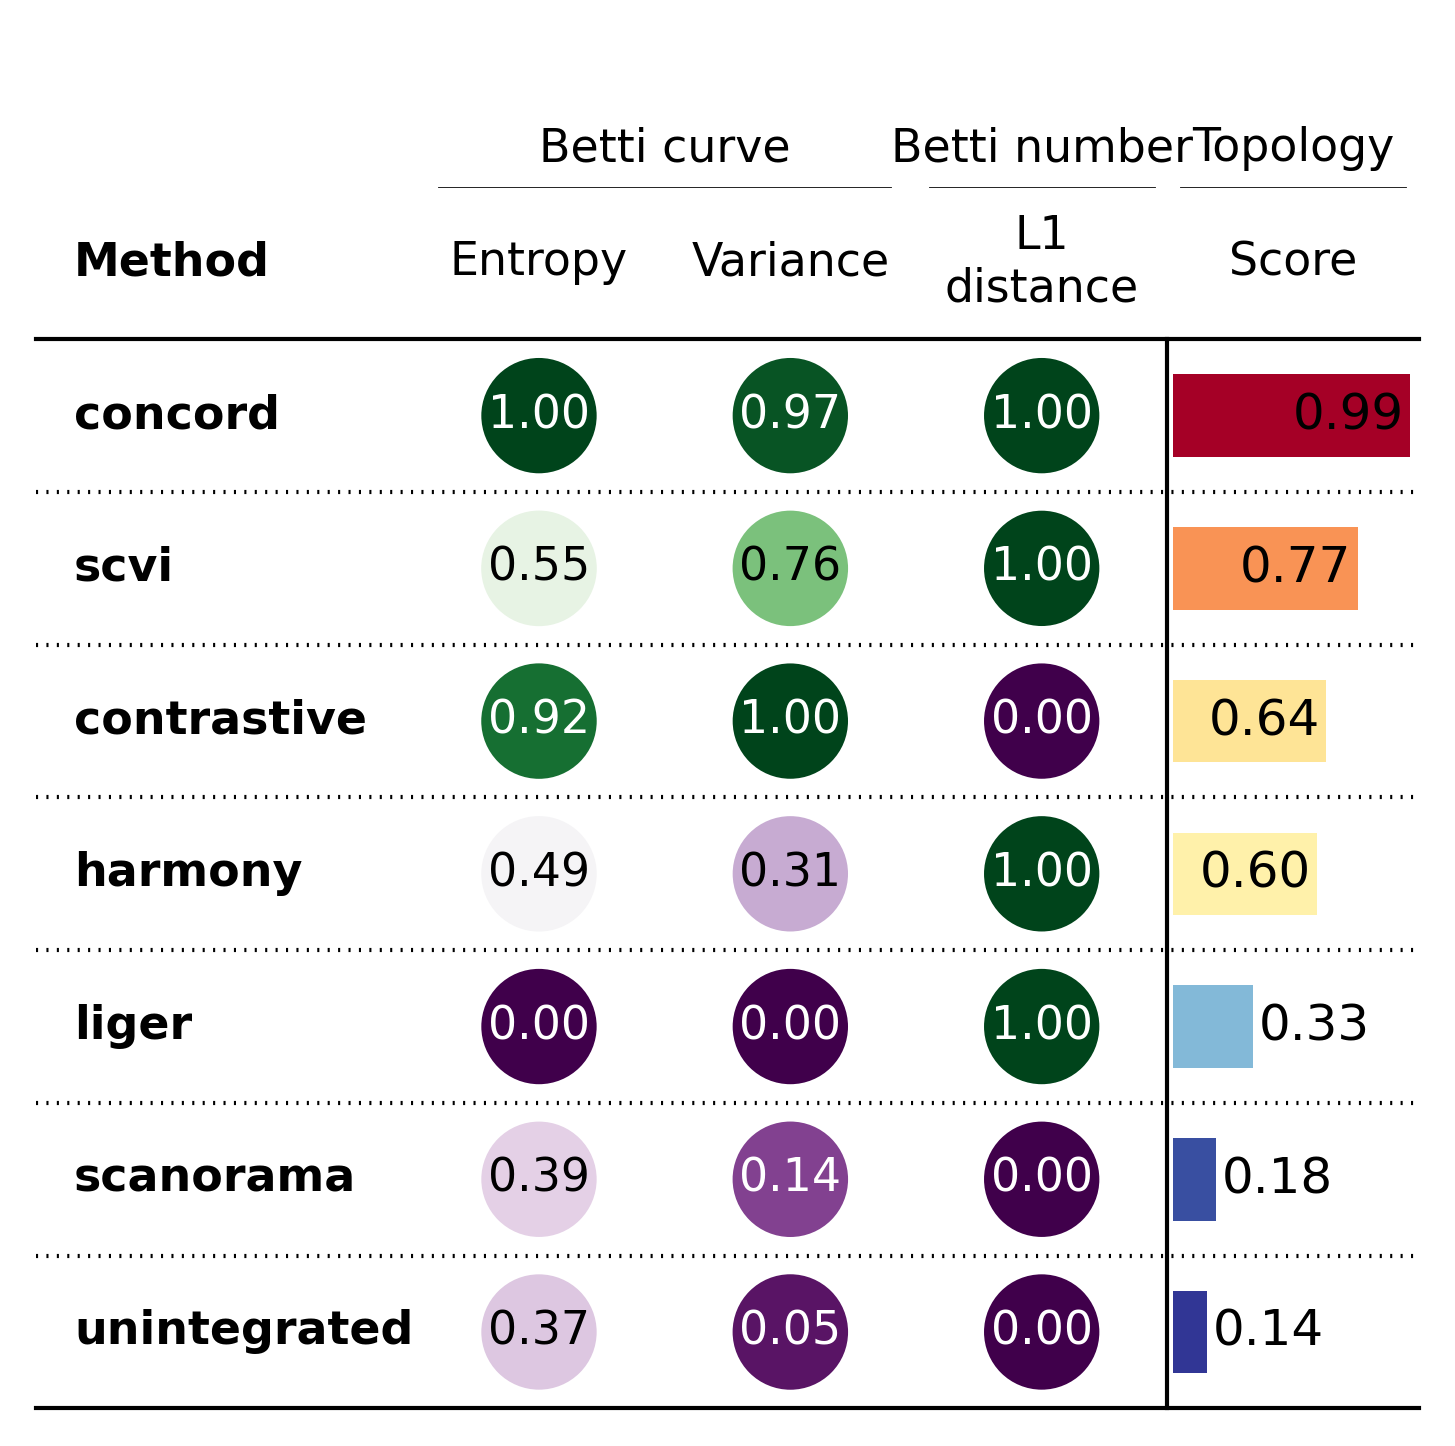

In [56]:
topology_results = ccd.bm.benchmark_topology(diagrams, expected_betti_numbers=[0,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics']
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.bm.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 6), dpi=300)

In [60]:
diagrams_ordered.keys()

dict_keys(['unintegrated', 'scanorama', 'liger', 'harmony', 'scvi', 'concord', 'contrastive'])

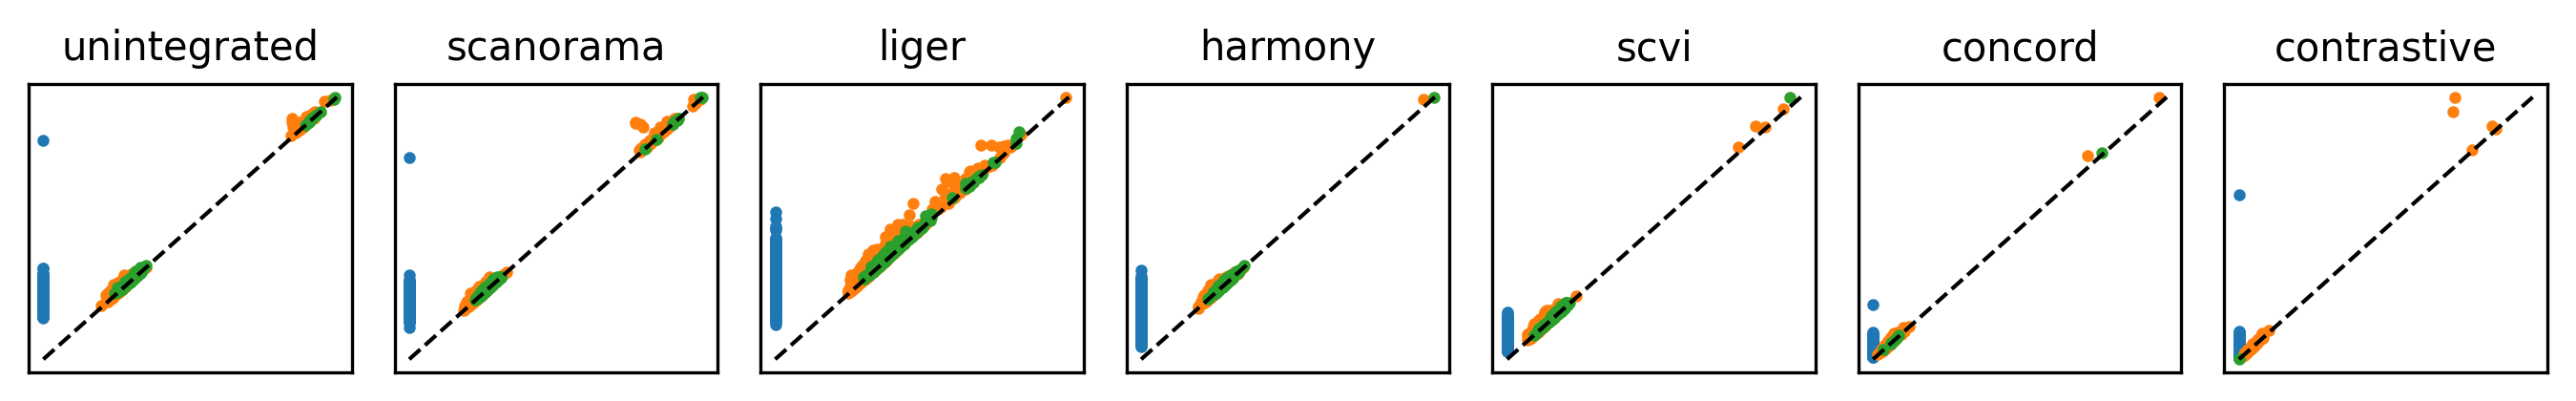

In [61]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

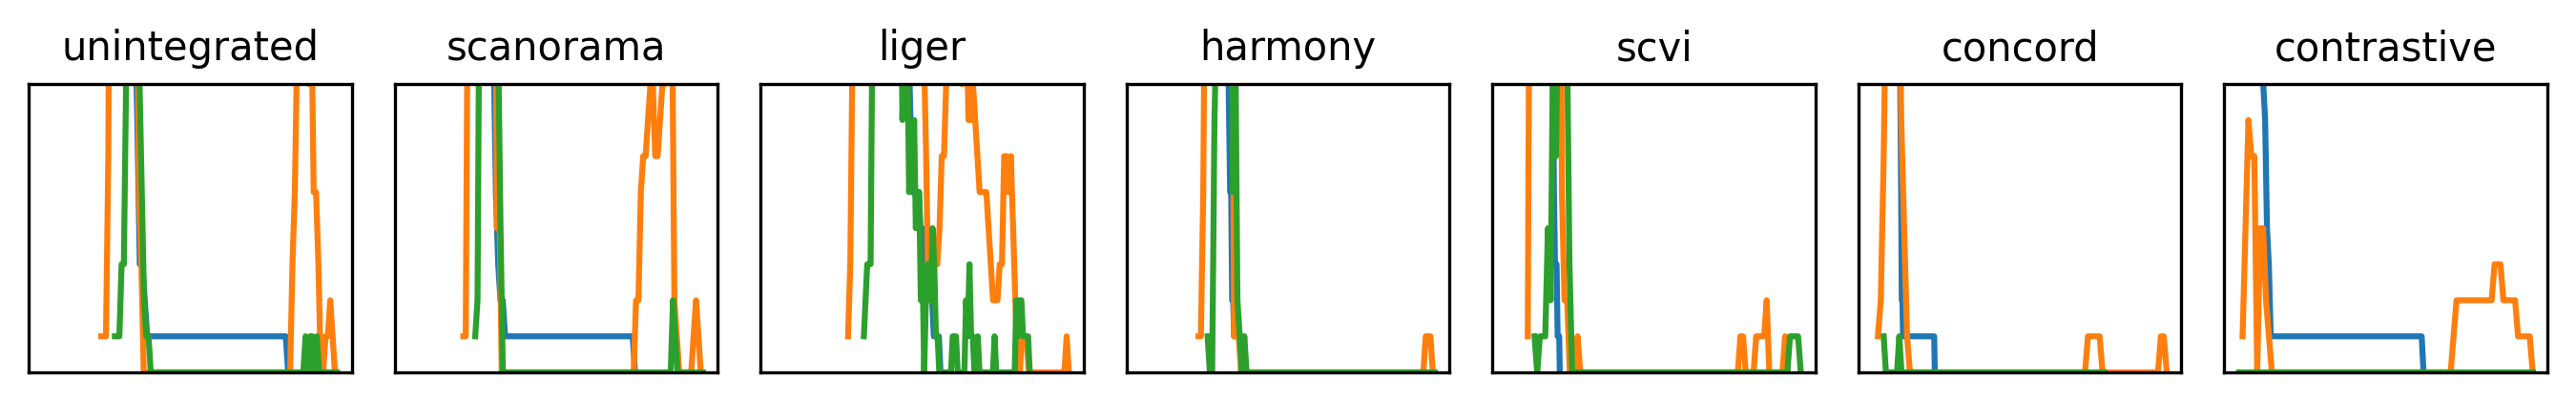

In [62]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

# Geomtric Features 

### Integrated benchmark pipeline

In [72]:
geometry_metrics = ['cell_distance_corr', 'trustworthiness', 'state_dispersion_corr', 'state_batch_distance_ratio']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'PCA_wt_noise'
groundtruth_key = 'no_noise'
bm_keys = ['no_noise', 'wt_noise'] + combined_keys
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.bm.benchmark_geometry(
    adata, 
    keys=bm_keys, 
    eval_metrics=geometry_metrics, 
    dist_metric=dist_metric,
    corr_types = corr_types,
    groundtruth_key = groundtruth_key,
    state_key = leiden_key,
    batch_key = batch_key,
    #groundtruth_dispersion = groundtruth_dispersion,
    dispersion_metric='var',
    return_type='full',
    start_point=0,
    end_point=adata.n_obs-1,
    pseudotime_k = 30,
    truetime_key = 'time',
    save_dir=save_dir, 
    file_suffix=file_suffix)

INFO:concord.benchmarking.benchmark:Computing cell distance correlation
INFO:concord.benchmarking.benchmark:Computing trustworthiness
INFO:concord.benchmarking.benchmark:Computing state dispersion correlation
INFO:concord.benchmarking.benchmark:Computing state-batch distance ratio


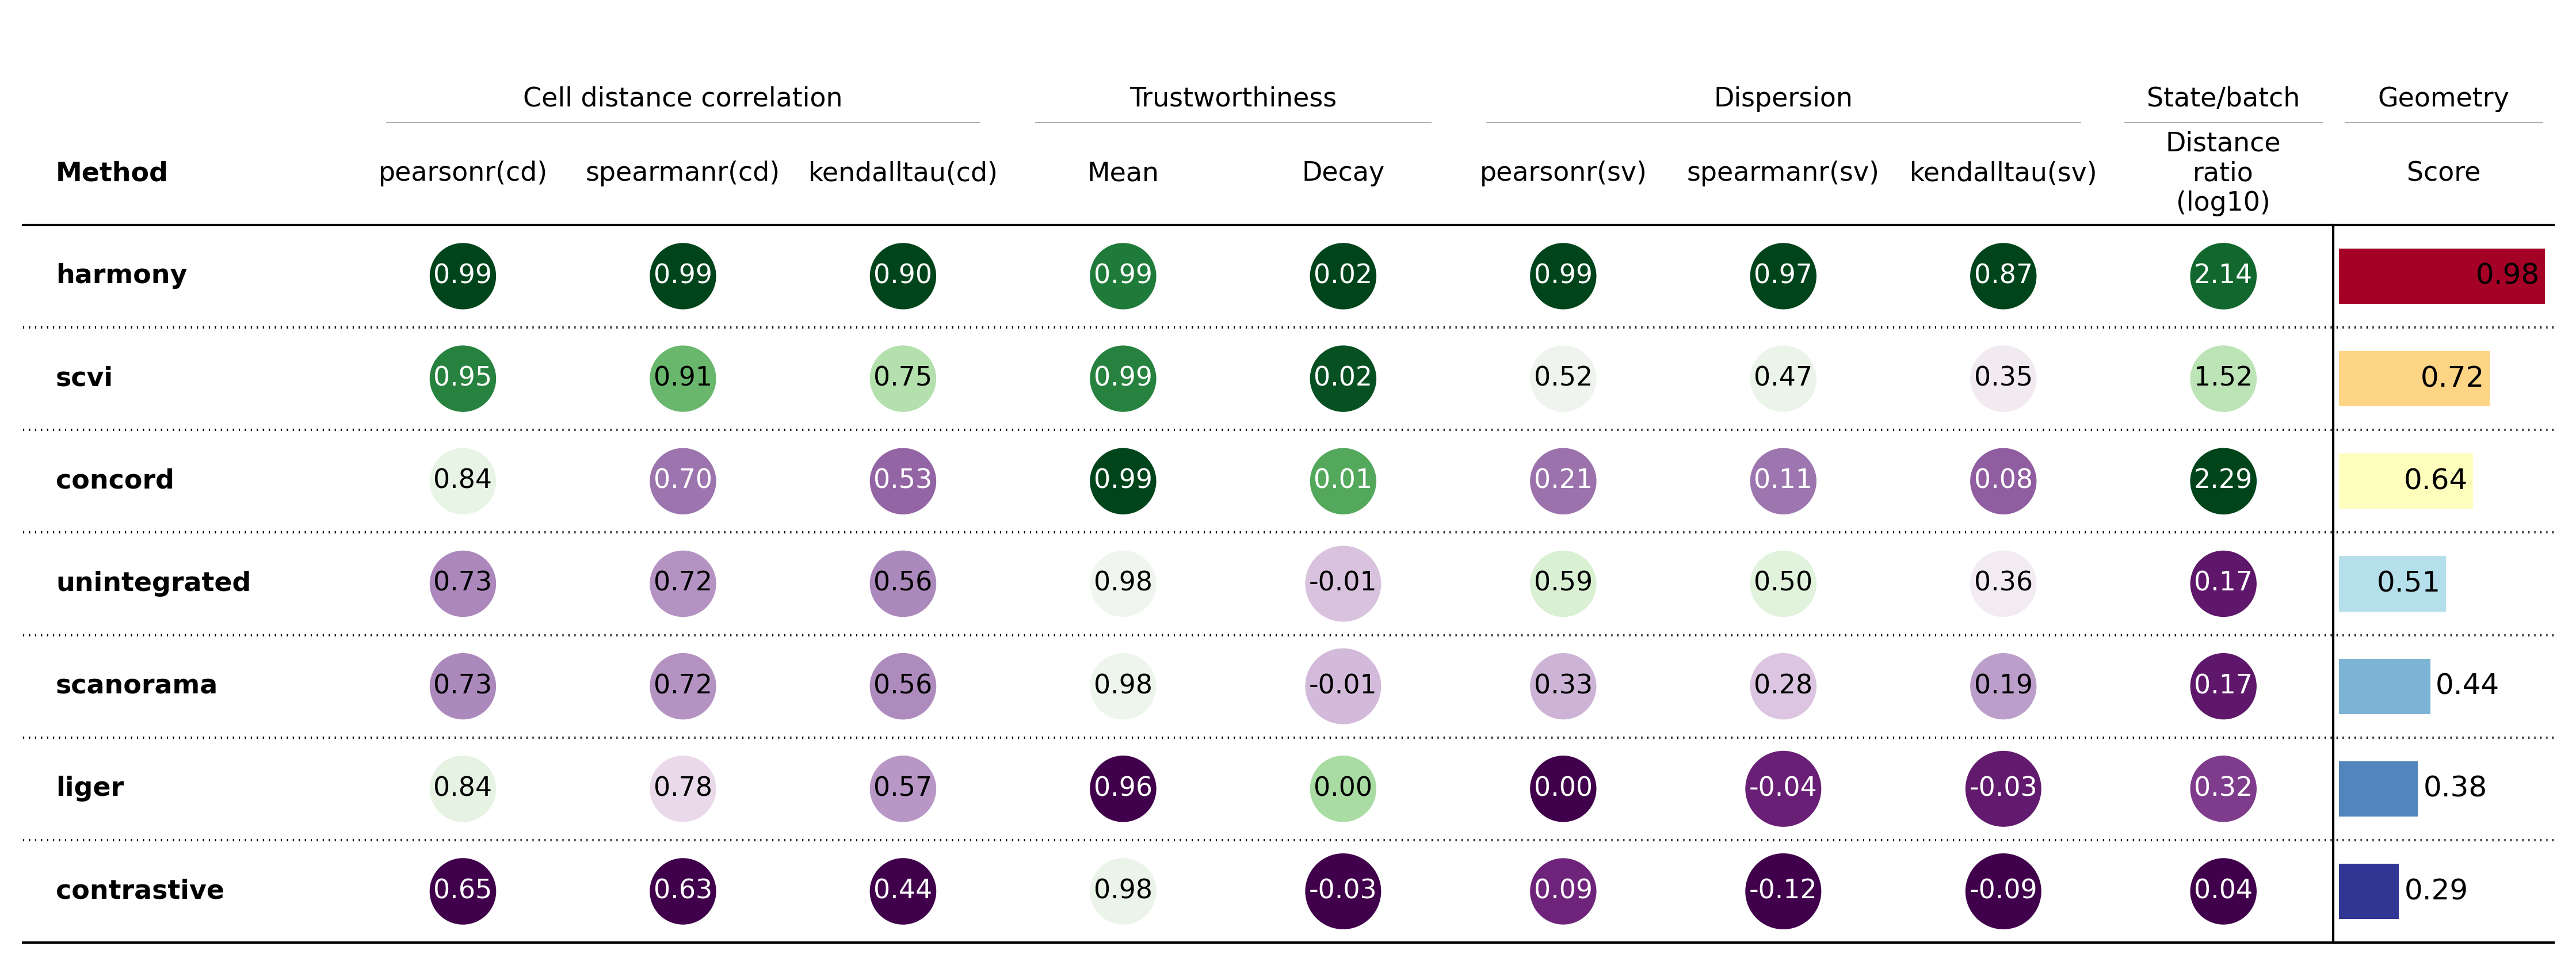

In [73]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.bm.benchmark_stats_to_score(
    geometry_df.drop(index=['no_noise', 'wt_noise']), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 7), dpi=300)

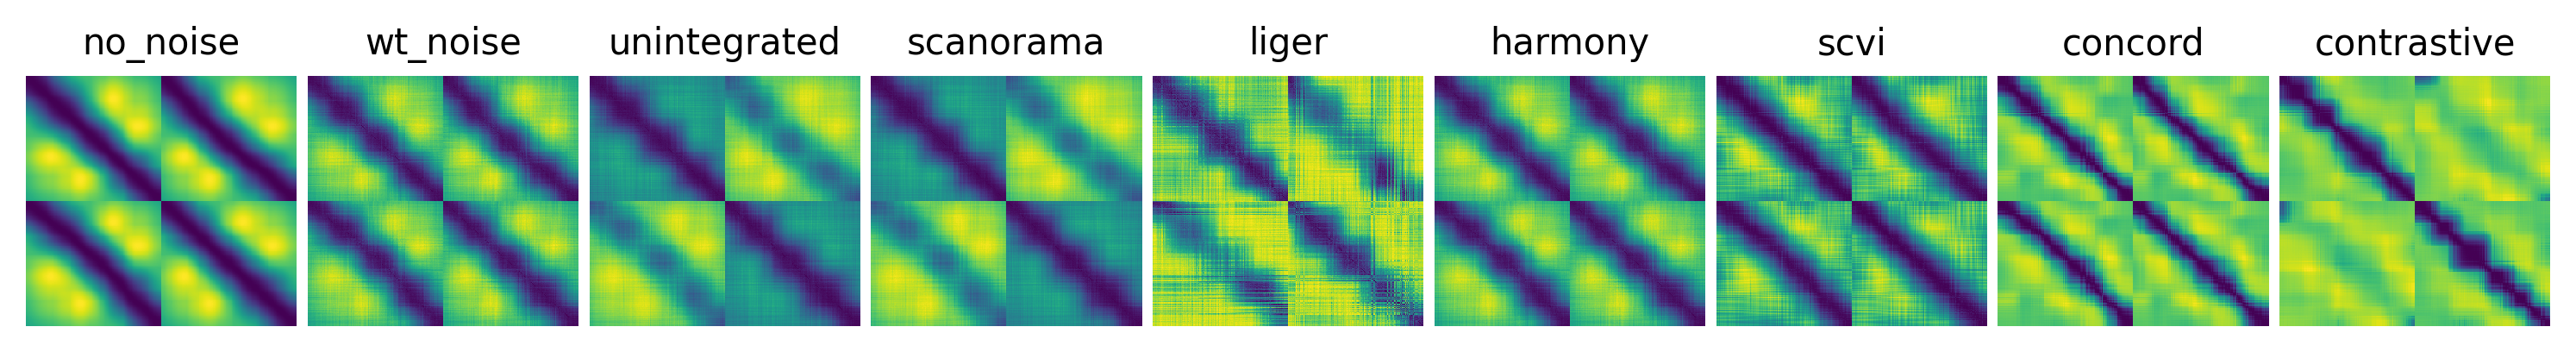

In [76]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = len(geometry_full['cell_distance_corr']['distance']), figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.pdf")

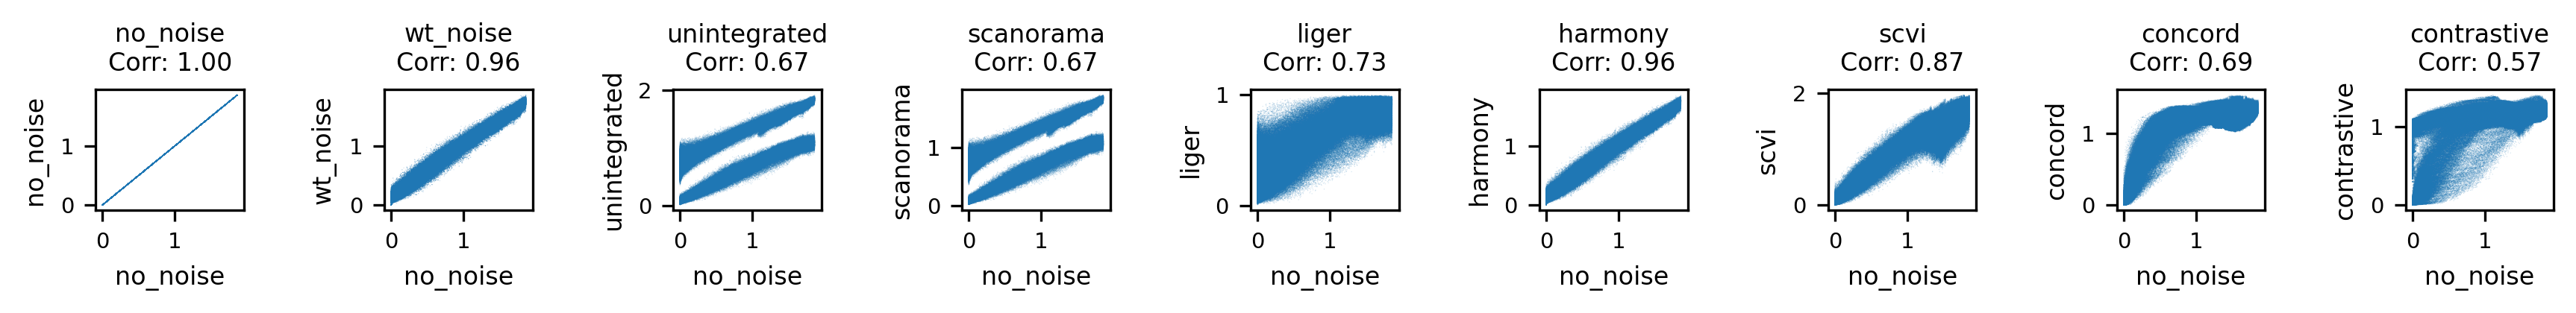

In [80]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['cell_distance_corr']['distance'], 
    correlation= geometry_full['cell_distance_corr']['correlation'],
    ground_key = groundtruth_key,
    s=0.1, alpha = 0.2,
    n_cols = len(geometry_full['cell_distance_corr']['distance']), figsize=(1.3,1.5), dpi=300, save_path=save_dir / f"cell_distance_scatter_{file_suffix}.png")

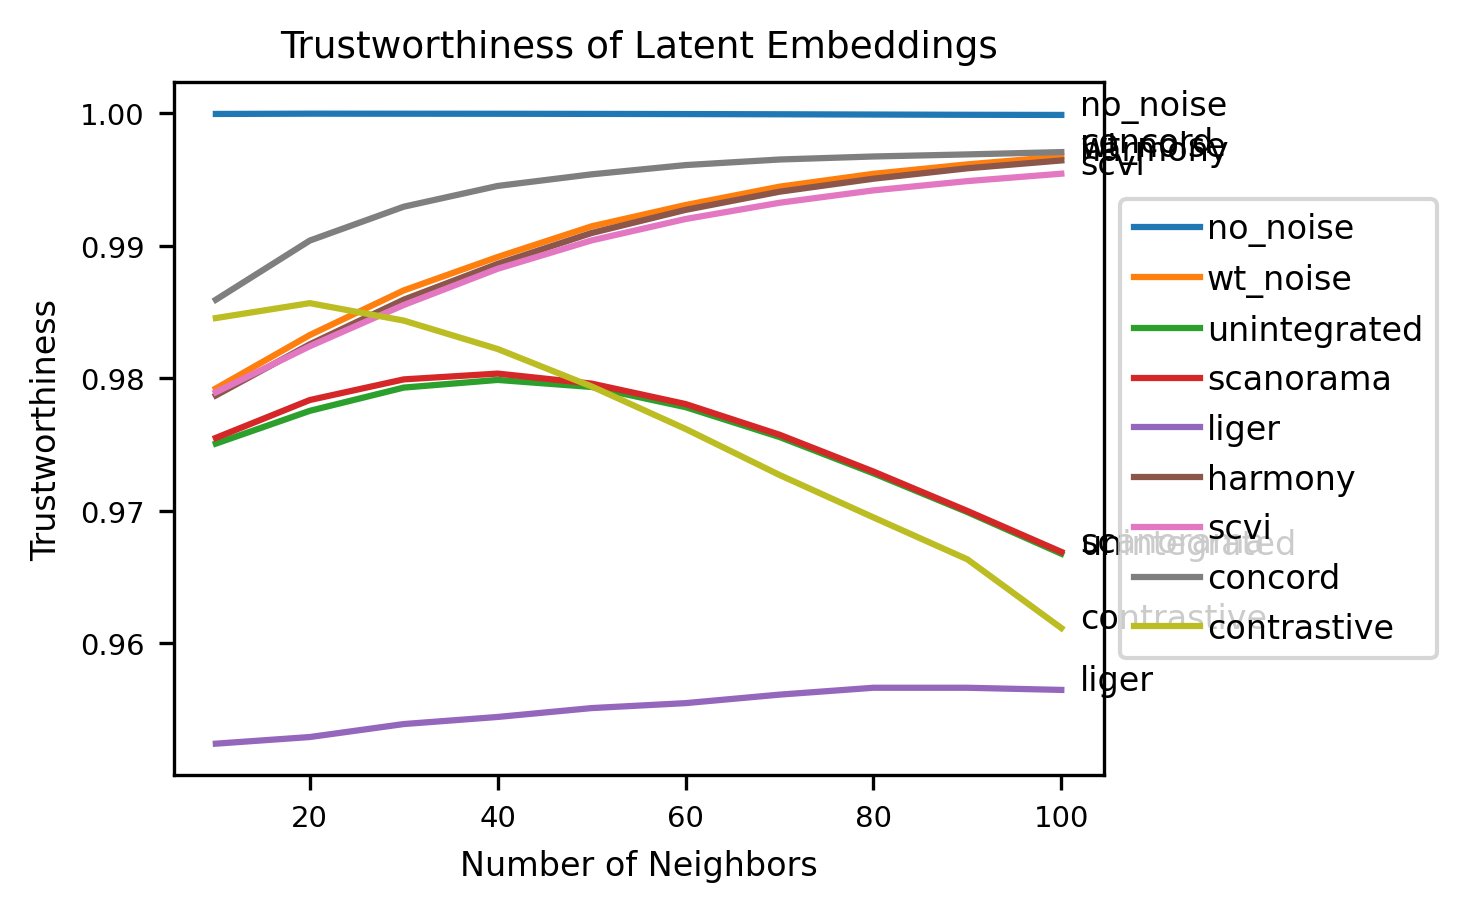

In [81]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=True, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))